In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the DataFrame
df = pd.read_csv("soilmoisture_dataset.csv", index_col=0)

# Get hyperspectral bands:
hypbands = []
for col in df.columns:
    try:
        int(col)
    except Exception:
        continue
    hypbands.append(col)

# Prepare the data by dropping unnecessary columns
data = df.drop(['soil_temperature', 'datetime'], axis=1)

# Standard scaling the data
scaler = StandardScaler()  # Create a StandardScaler instance

# Fit and transform the data for the hyperspectral bands
data_scaled = scaler.fit_transform(data[hypbands])

# Convert the scaled data back to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=hypbands)

# Prepare the data
X = data_scaled_df  # The scaled feature set
y = data["soil_moisture"]

X.head()


,454,458,462,466,470,474,478,482,486,490,...,914,918,922,926,930,934,938,942,946,950
0,-0.820790,-0.933076,-0.911946,-0.918558,-0.895983,-0.937692,-0.916785,-0.917529,-0.909948,-0.898783,...,-0.895534,-0.906420,-0.902073,-0.867279,-0.844442,-0.848906,-0.847418,-0.852499,-0.864668,-0.841753
1,-0.913318,-0.962229,-0.968456,-0.940140,-0.942926,-0.914833,-0.937676,-0.906206,-0.898575,-0.918568,...,-0.898902,-0.893785,-0.885898,-0.884148,-0.878898,-0.883832,-0.864402,-0.819999,-0.794575,-0.770620
2,-0.874888,-1.030703,-0.966399,-0.942754,-0.956636,-0.964497,-0.940893,-0.914399,-0.924247,-0.898582,...,-0.908062,-0.918278,-0.894888,-0.875008,-0.855017,-0.851385,-0.823587,-0.819934,-0.828697,-0.827617
3,-0.965790,-0.981437,-0.972359,-0.918834,-0.934312,-0.918411,-0.906604,-0.907706,-0.904218,-0.907212,...,-0.884202,-0.870745,-0.861303,-0.847263,-0.852920,-0.851014,-0.828813,-0.810390,-0.758144,-0.742757
4,-0.896976,-0.961759,-0.956435,-0.953026,-0.925257,-0.906755,-0.911004,-0.904376,-0.873318,-0.924056,...,-0.896620,-0.894235,-0.892517,-0.867538,-0.843084,-0.825724,-0.800567,-0.786257,-0.783971,-0.784635


In [41]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare the data
X = data_scaled_df  # The scaled feature set
y = data["soil_moisture"]

# Create the Random Forest Regressor
rfr_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15)

# Initialize KFold for 10 splits
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Lists to store metrics for each fold
rmse_list = []
adjusted_r2_list = []

# Perform 10-fold cross-validation
fold_number = 1
for train_index, test_index in kf.split(X):
    # Split data into training and testing for each fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    rfr_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rfr_model.predict(X_test)

    # Calculate RMSE for the fold
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_list.append(rmse)

    # Calculate R-squared and adjusted R-squared for the fold
    r_squared = r2_score(y_test, y_pred)
    n = len(y_test)  # Number of observations in the fold
    p = X_test.shape[1]  # Number of features
    adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
    adjusted_r2_list.append(adjusted_r_squared)

    # Log results for each fold
    print(f"Fold {fold_number}:")
    print(f"  R-squared: {round(r_squared, 4)}")
    print(f"  Adjusted R-squared: {round(adjusted_r_squared, 4)}")
    print(f"  RMSE: {round(rmse, 3)}")
    fold_number += 1

# Average metrics across folds
avg_rmse = np.mean(rmse_list)
avg_adjusted_r2 = np.mean(adjusted_r2_list)

# Print the average results
print("\nAverage Root Mean Square Error (RMSE):", round(avg_rmse, 4))
print("Average Adjusted R-squared:", round(avg_adjusted_r2, 4))



Fold 1:
  R-squared: 0.9344
  Adjusted R-squared: 0.8961
  RMSE: 0.949
Fold 2:
  R-squared: 0.9126
  Adjusted R-squared: 0.8613
  RMSE: 1.058

Average Root Mean Square Error (RMSE): 1.0033
Average Adjusted R-squared: 0.8787


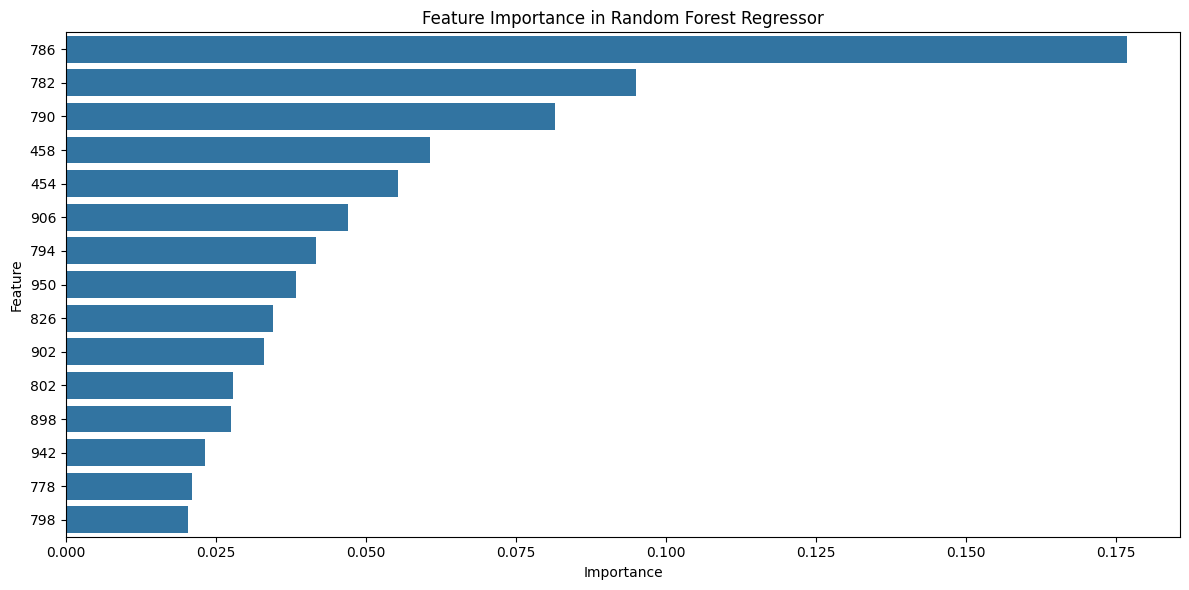

['786', '782', '790', '458', '454', '906', '794', '950', '826', '902', '802', '898', '942', '778', '798']


In [42]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate feature importance
importance = rfr_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': data_scaled_df.columns,
    'Importance': importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a list of the top 15 features
top_15_features = feature_importance_df.head(15)['Feature'].tolist()

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))  # Display top 15 features
plt.title('Feature Importance in Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()  # Adjust layout for better display
plt.show()  # Ensure this is called to display the plot

print(top_15_features)




In [44]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# features = ['950', '454', '790', '782', '794', '826', '946', '818', '934', '786', '458', '942', '830', '766', '906']
X = X[top_15_features]
y = df['soil_moisture']

# Initialize lists to store results
rmse_results = []
adjusted_r2_results = []

# Number of folds
n_folds = 5

# Cross-validation setup
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Perform training with an increasing number of features
for i in range(1, len(top_15_features) + 1):
    # Select the first i features
    selected_features = top_15_features[:i]
    X_subset = X[selected_features]
    
    # SVR model
    model = SVR(kernel='rbf', C=1000, gamma='scale')
    
    # Cross-validated predictions
    y_pred = cross_val_predict(model, X_subset, y, cv=kf)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    rmse_results.append(rmse)
    
    # Calculate Adjusted R²
    n = len(y)  # Number of samples
    p = i       # Number of predictors (features)
    r2 = r2_score(y, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    adjusted_r2_results.append(adjusted_r2)
    
    # Print results for each iteration
    print(f"Iteration {i} (using {i} features):")
    print(f"Selected features: {selected_features}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Adjusted R²: {adjusted_r2:.4f}")
    print("-" * 40)

# Results summary
print("Summary of RMSE for each feature set:", rmse_results)
print("Summary of Adjusted R² for each feature set:", adjusted_r2_results)

Iteration 1 (using 1 features):
Selected features: ['786']
RMSE: 1.8240
Adjusted R²: 0.7489
----------------------------------------
Iteration 2 (using 2 features):
Selected features: ['786', '782']
RMSE: 1.8279
Adjusted R²: 0.7474
----------------------------------------
Iteration 3 (using 3 features):
Selected features: ['786', '782', '790']
RMSE: 1.8213
Adjusted R²: 0.7489
----------------------------------------
Iteration 4 (using 4 features):
Selected features: ['786', '782', '790', '458']
RMSE: 1.5185
Adjusted R²: 0.8252
----------------------------------------
Iteration 5 (using 5 features):
Selected features: ['786', '782', '790', '458', '454']
RMSE: 1.2853
Adjusted R²: 0.8746
----------------------------------------
Iteration 6 (using 6 features):
Selected features: ['786', '782', '790', '458', '454', '906']
RMSE: 1.2762
Adjusted R²: 0.8762
----------------------------------------
Iteration 7 (using 7 features):
Selected features: ['786', '782', '790', '458', '454', '906', '79